In [215]:
import pandas as pd
import os

census_data = pd.read_csv(os.path.join(os.path.abspath(""), "census_by_age.csv"))

death_data = pd.read_csv(os.path.join(os.path.abspath(""), "death_data.csv"))


In [239]:
ages = [
    "1-4 years",
    "5-14 years",
    "15-24 years",
    "25-34 years",
    "35-44 years",
    "45-54 years",
    "55-64 years",
    "65-74 years",
    "75-84 years",
    "85 years and over",
]


In [240]:
census_data["AGE_BINS"] = pd.cut(
    census_data["AGE"],
    bins=[1, 4, 14, 24, 34, 44, 54, 64, 74, 84, 100],
    labels=ages,
)


In [217]:
grouped_census_data = (
    census_data.loc[census_data["SEX"] == 0, ["NAME", "AGE_BINS", "POPEST2019_CIV"]]
    .groupby(["NAME", "AGE_BINS"], as_index=False)
    .sum()
)


In [218]:
death_data.columns


Index(['Data As Of', 'Start Date', 'End Date', 'Group', 'Year', 'Month',
       'State', 'Sex', 'Age Group', 'COVID-19 Deaths', 'Total Deaths',
       'Pneumonia Deaths', 'Pneumonia and COVID-19 Deaths', 'Influenza Deaths',
       'Pneumonia, Influenza, or COVID-19 Deaths', 'Footnote'],
      dtype='object')

In [219]:
death_data.groupby(["Start Date", "End Date"]).size().reset_index().rename(
    columns={0: "count"}
)


,Start Date,End Date,count
0,01/01/2020,01/08/2022,2754
1,01/01/2020,01/31/2020,2754
2,01/01/2020,12/31/2020,2754
3,01/01/2021,01/31/2021,2754
4,01/01/2021,12/31/2021,2754
5,01/01/2022,01/08/2022,5508
6,02/01/2020,02/29/2020,2754
7,02/01/2021,02/28/2021,2754
8,03/01/2020,03/31/2020,2754
9,03/01/2021,03/31/2021,2754


In [220]:
date_ranges = [
    ("01/01/2020", "01/31/2020"),
    ("02/01/2020", "02/29/2020"),
    ("03/01/2020", "03/31/2020"),
    ("04/01/2020", "04/30/2020"),
    ("05/01/2020", "05/31/2020"),
    ("06/01/2020", "06/30/2020"),
    ("07/01/2020", "07/31/2020"),
    ("08/01/2020", "08/31/2020"),
    ("09/01/2020", "09/30/2020"),
    ("10/01/2020", "10/31/2020"),
    ("11/01/2020", "11/30/2020"),
    ("12/01/2020", "12/31/2020"),
    ("01/01/2021", "01/31/2021"),
    ("02/01/2021", "02/28/2021"),
    ("03/01/2021", "03/31/2021"),
    ("04/01/2021", "04/30/2021"),
    ("05/01/2021", "05/31/2021"),
    ("06/01/2021", "06/30/2021"),
    ("07/01/2021", "07/31/2021"),
    ("08/01/2021", "08/31/2021"),
    ("09/01/2021", "09/30/2021"),
    ("10/01/2021", "10/31/2021"),
    ("11/01/2021", "11/30/2021"),
    ("12/01/2021", "12/31/2021"),
    ("01/01/2022", "01/08/2022"),
]


In [221]:
usa_totals = grouped_census_data.loc[
    grouped_census_data.loc[:, "NAME"] == "United States", :
].copy()
total_pop = usa_totals.loc[:, "POPEST2019_CIV"].sum()
usa_totals.loc[:, "percent_in_group"] = usa_totals.loc[:, "POPEST2019_CIV"] / total_pop
usa_totals


,NAME,AGE_BINS,POPEST2019_CIV,percent_in_group
440,United States,1-4 years,11964032,0.037453
441,United States,5-14 years,40994163,0.128331
442,United States,15-24 years,42250205,0.132263
443,United States,25-34 years,45482275,0.142381
444,United States,35-44 years,41430182,0.129696
445,United States,45-54 years,40816619,0.127776
446,United States,55-64 years,42444212,0.132871
447,United States,65-74 years,31483433,0.098558
448,United States,75-84 years,15969872,0.049993
449,United States,85 years and over,6604958,0.020677


In [222]:
age_bins = grouped_census_data[grouped_census_data["NAME"] == "United States"][
    "AGE_BINS"
]


In [245]:
def calculate_adjusted_deaths(month):
    grouped_death_data = (
        death_data[
            (death_data["Sex"] == "All Sexes")
            & (
                death_data[["Start Date", "End Date"]]
                .apply(tuple, axis=1)
                .isin(date_ranges[:month])
            )
        ]
        .groupby(["State", "Age Group"], as_index=False)["COVID-19 Deaths"]
        .sum()
    )

    merged_data = grouped_death_data.merge(
        grouped_census_data,
        left_on=["State", "Age Group"],
        right_on=["NAME", "AGE_BINS"],
    ).merge(usa_totals[["AGE_BINS", "percent_in_group"]], on=["AGE_BINS"])
    merged_data.loc[:, "Death Divided By Population"] = (
        merged_data.loc[:, "COVID-19 Deaths"]
        / merged_data.loc[:, "POPEST2019_CIV"]
        * 100000
        * merged_data.loc[:, "percent_in_group"]
    )
    # return merged_data
    return (
        merged_data[["State", "Death Divided By Population"]].groupby(["State"]).sum()
    )


In [243]:
def calculate_deaths(month):
    grouped_death_data = (
        death_data[
            (death_data["Sex"] == "All Sexes")
            & death_data["Age Group"].isin(ages)
            & (
                death_data[["Start Date", "End Date"]]
                .apply(tuple, axis=1)
                .isin(date_ranges[:month])
            )
        ]
        .groupby(["State"], as_index=False)["COVID-19 Deaths"]
        .sum()
    )
    new_census_data = grouped_census_data.groupby(["NAME"], as_index=False)[
        "POPEST2019_CIV"
    ].sum()
    merged_data = grouped_death_data.merge(
        new_census_data, left_on=["State"], right_on=["NAME"]
    )
    merged_data.loc[:, "Deaths by 100k"] = (
        merged_data.loc[:, "COVID-19 Deaths"]
        / merged_data.loc[:, "POPEST2019_CIV"]
        * 100000
    )
    return merged_data


In [244]:
calculate_deaths(100)


,State,COVID-19 Deaths,NAME,POPEST2019_CIV,Deaths by 100k
0,Alabama,16133.0,Alabama,4774156,337.923604
1,Alaska,729.0,Alaska,692124,105.327947
2,Arizona,23027.0,Arizona,7094096,324.593859
3,Arkansas,9115.0,Arkansas,2939181,310.120404
4,California,80823.0,California,38430839,210.307665
5,Colorado,10785.0,Colorado,5593367,192.817671
6,Connecticut,8995.0,Connecticut,3488215,257.868279
7,Delaware,2055.0,Delaware,949055,216.531181
8,District of Columbia,1272.0,District of Columbia,682806,186.290103
9,Florida,60368.0,Florida,20964005,287.960244


In [246]:
calculate_adjusted_deaths(100)


,Death Divided By Population
State,
Alabama,329.824212
Alaska,140.629013
Arizona,313.173749
Arkansas,302.349554
California,226.819314
Colorado,222.865025
Connecticut,226.721022
Delaware,193.908685
District of Columbia,240.485088


In [247]:
red_america = [
    "Texas",
    "Florida",
    "Ohio",
    "North Carolina",
    "Indiana",
    "Tennessee",
    "Missouri",
    "Alabama",
    "South Carolina",
    "Kentucky",
    "Louisiana",
    "Oklahoma",
    "Mississippi",
    "Iowa",
    "Arkansas",
    "Kansas",
    "Utah",
    "West Virginia",
    "Idaho",
    "Nebraska",
    "Alaska",
    "Montana",
    "North Dakota",
    "South Dakota",
    "Wyoming",
]
blue_america = [
    "California",
    "New York",
    "Illinois",
    "Pennsylvania",
    "Michigan",
    "New Jersey",
    "Virginia",
    "Washington",
    "Arizona",
    "Massachussets",
    "Maryland",
    "Minnesota",
    "Wisconsin",
    "Colorado",
    "Connecticut",
    "Oregon",
    "Nevada",
    "New Mexico",
    "Hawaii",
    "New Hampshire",
    "Rhode Island",
    "Delaware",
    "District of Columbia",
    "Maine",
    "Vermont",
]


In [270]:
def calculate_adjusted_deaths_by_party(month):
    grouped_death_data = (
        death_data.loc[
            (death_data["Sex"] == "All Sexes")
            & (
                death_data[["Start Date", "End Date"]]
                .apply(tuple, axis=1)
                .isin(date_ranges[:month])
            )
        ]
        .groupby(["State", "Age Group"], as_index=False)["COVID-19 Deaths"]
        .sum()
    )

    merged_data = grouped_death_data.merge(
        grouped_census_data,
        left_on=["State", "Age Group"],
        right_on=["NAME", "AGE_BINS"],
    )
    
    merged_data.loc[merged_data["State"].isin(red_america), "Political Party"] = "RED"
    merged_data.loc[merged_data["State"].isin(blue_america), "Political Party"] = "BLUE"
    
    summed_by_party = merged_data.groupby(["Political Party", "Age Group"], as_index=False)["COVID-19 Deaths", "POPEST2019_CIV"].sum()

    summed_by_party = summed_by_party.merge(usa_totals[["AGE_BINS", "percent_in_group"]], left_on=["Age Group"],right_on=["AGE_BINS"])

    summed_by_party.loc[:, "Death Divided By Population"] = (
        summed_by_party.loc[:, "COVID-19 Deaths"]
        / summed_by_party.loc[:, "POPEST2019_CIV"]
        * 100000
        * summed_by_party.loc[:, "percent_in_group"]
    )

    # return summed_by_party
    return (
        summed_by_party[["Political Party", "Death Divided By Population"]].groupby(["Political Party"]).sum()
    )


In [271]:
calculate_adjusted_deaths_by_party(4)

/tmp/ipykernel_76043/3788121796.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summed_by_party = merged_data.groupby(["Political Party", "Age Group"], as_index=False)["COVID-19 Deaths", "POPEST2019_CIV"].sum()


,Death Divided By Population
Political Party,
BLUE,23.421661
RED,7.309454


In [276]:

x = range(1, 25)
y = [calculate_adjusted_deaths_by_party(a) for a in x]


/tmp/ipykernel_76043/3788121796.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  summed_by_party = merged_data.groupby(["Political Party", "Age Group"], as_index=False)["COVID-19 Deaths", "POPEST2019_CIV"].sum()


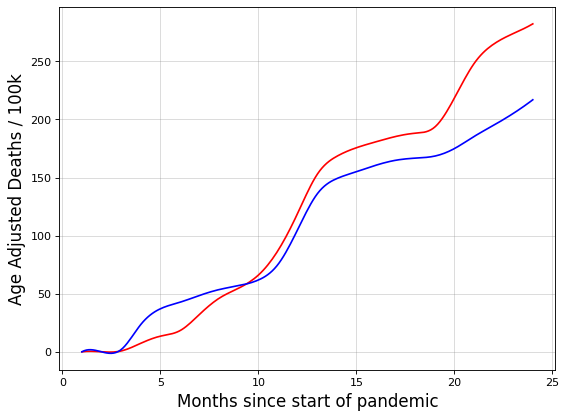

In [308]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

plt.figure(figsize=(8, 6), dpi=80)
red = [a.loc["RED"]["Death Divided By Population"] for a in y]
blue = [a.loc["BLUE"]["Death Divided By Population"] for a in y]

x_smooth = np.linspace(x[0], x[-1], 200)
spl_red = make_interp_spline(x, red, k=3)
spl_blue = make_interp_spline(x, blue, k=3)

plt.plot(x_smooth, spl_red(x_smooth), "r")
plt.plot(x_smooth, spl_blue(x_smooth), "b")
plt.grid(visible=True, color="gray", alpha=0.3, linestyle="-")
plt.xlabel('Months since start of pandemic', fontsize=15)
plt.ylabel('Age Adjusted Deaths / 100k', fontsize=15)
plt.show()